# Deep Learning
## Practical Session 04
Görkem Saygili & Busra Ozgode Yigin, Department of Cognitive Science and Artificial Intelligence – Tilburg University

# Recurrent Neural Networks

In this tutorial, we will focus on the analysis of electroencephalography (EEG) data, which is complex, weak, multivariate, nonlinear, and nonstationary time series, has been recently widely applied in neurocognitive disorder diagnoses and brain-machine interface developments.

EEG data is frequently used in psychology and neuroscience, e.g. in seizure or stroke detection, as well as in areas such as emotion prediction and customer's behavior prediction.

Epileptic Seizure Recognition, publicly available dataset will be analyzed in this study using a simple recurrent neural network. This data can be found here: https://www.kaggle.com/datasets/harunshimanto/epileptic-seizure-recognition .



Online resources that are used while preparing this tutorial:
<div class="alert alert-block alert-info">
    
[1] https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

[2] https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/.

</div>


First of all, we need to import libraries:

In [ ]:
import keras
# Remove some unwanted warnings
import logging
logging.getLogger('tensorflow').disabled = True
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt

### Epileptic Seizure Recognition Dataset

This dataset is a pre-processed and re-structured/reshaped version of a commonly used dataset featuring epileptic seizure detection.

- The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds.

- The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have a total of 500 individuals that each has 4097 data points for 23.6 seconds.

- Every 4097 data points were divided and shuffled into 23 chunks, each chunk contains 178 data points for a second, and each data point is the value of the EEG recording at a different point in time.

- In total there are 23 x 500 = 11500 pieces of information (row), each containing 178 data points for one second (column), the last column represents the label y {1,2,3,4,5}. All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure (combine all these classes to do binary classification). Only subjects in class 1 have epileptic seizure.

The response variable is y in column 179, the Explanatory variables X1, X2, ..., X178

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#you need to change the direction of your dataset
Data = pd.read_csv('/content/drive/MyDrive/ELECTIVE: Deep Learning/PRACTICALS/Practical 4/Epileptic_Seizure_Recognition.csv')
Data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


## Exercise 1 - Preprocessing Data

As the aim of this study is detecting epileptic seizure, although there are 5 classes we will apply binary classification, namely class 1 (Epileptic seizure) against the rest. In order to train our model, let's define our independent variables (X) and our dependent variable (y).

<ipython-input-12-156042b6dae6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tgt[tgt>1] = 0


The number of trials for the non-seizure class is: 9200
The number of trials for the seizure class is: 2300


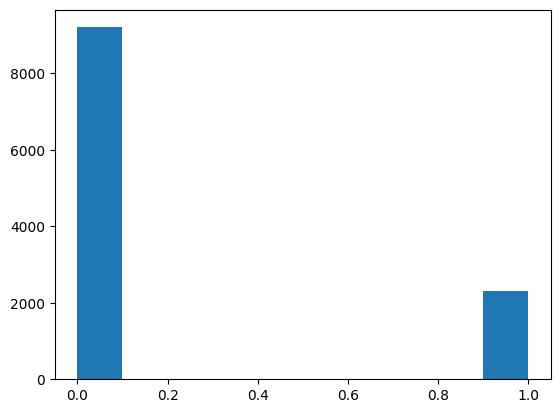

In [ ]:
cols = Data.columns
tgt = Data.y

#assign all the calesses as non-seizure except from 1 - subjects with epileptic seizure
tgt[tgt>1] = 0

#to see the number of samples from each class
#ax = sn.countplot(tgt,label="Count")
plt.hist(tgt)

non_seizure, seizure = tgt.value_counts()
print('The number of trials for the non-seizure class is:', non_seizure)
print('The number of trials for the seizure class is:', seizure)

There is imbalance data. Accuracy is not a good measure for datasets with big imbalances. However, F1-score could be an alternative measure for these cases

In [ ]:
X = Data.iloc[:,1:179].values # the 0th column ('unnamed') will not be used
print(X.shape)
y = Data.iloc[:,179].values
print(y)

(11500, 178)
[0 1 0 ... 0 0 0]


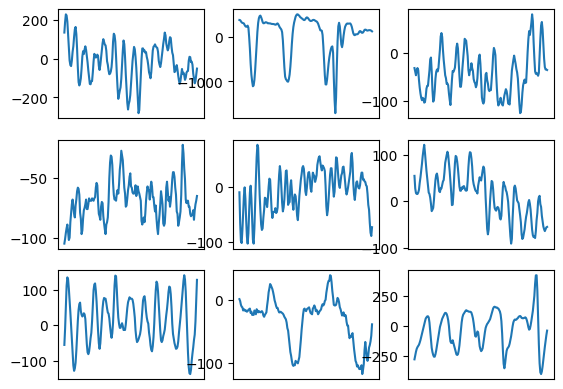

In [ ]:
#Let's visualize some samples of EEG signals
# plot first few images
for i in range(9):
	# define subplot
	ax = plt.subplot(331 + i)
	# plot raw pixel data
	plt.plot(X[i,:])
	ax.axes.xaxis.set_visible(False)
# show the figure
plt.show()

Let's first split the data into training and test sets and apply feature-wise standardization:

Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.


In [ ]:
from sklearn.model_selection import train_test_split

### PUT YOUR CODE HERE ###
#Splitting your data into train and test set with test_size of 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardization of training and testing input data
# Computing mean and standard deviation of the training data
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# Standardizing training and test data
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
### END ###


Often there is confusion about how to convert your sequence data that may be a 1D or 2D matrix of numbers to the required 3D format of the RNN input layer.

The 3D of the RNN input layer are:

- **Samples:** One sequence is one sample. A batch is comprised of one or more samples.
- **Time Steps:** One time step is one point of observation in the sample.
- **Features:** One feature is one observation at a time step. For example, each channel of an EEG recording corresponds to a feature.

This means that the input layer expects a 3D array of data (samples, time_steps, features) when fitting the model and when making predictions, even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

 * Reshape data from **[samples, timesteps]** into **[samples, timesteps, features]**:


In [ ]:
### PUT YOUR CODE HERE ###
X_train_series = np.reshape (X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_series = np.reshape (X_test, (X_test.shape[0], X_test.shape[1], 1))

### END ###
print('Train set shape', X_train_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (8050, 178, 1)
Test set shape (3450, 178, 1)


## Exercise 2 - Building simple RNN, GRU and LSTM models

Long Short-Term Memory Networks (LSTMs) are a special type of Recurrent neural networks (RNN). LSTMs can be used to learn features from EEG signals and then a dense layer is used for classification. RNNs and especially LSTMs are among the most popular deep neural network architectures for modeling the temporal characteristics of the brain activities.

Your model should include two RNN layers of 64 units. After each RNN layer, we will put a dropout layer of 0.2. We will use `tanh` activation function in RNN layers, and `sigmoid` for output layer.

Fill in the `build_model` function. Your model should use 3D array of EEG data. You should add a recurrent layer of 64 units, which type (e.g. `SimpleRNN`, `GRU`,`LSTM`) is specified through the parameter `rnn_layer_type`. This will allow us to easily compare the merits of the different types of layers.

To compile the model we will use `Adam` optimizer.
You can refer to https://keras.io/layers/recurrent for more information about recurrent layers in Keras.

In [ ]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, LSTM, GRU
keras.backend.clear_session()

def build_model(recurrent_layer_type):
    ### PUT YOUR CODE HERE ###
    model = Sequential()
    model.add(recurrent_layer_type(64, input_shape=(X_train_series.shape[1], X_train_series.shape[2]), activation = 'tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(recurrent_layer_type(64, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model
    ### END ###


Fit each model in a loop and monitor the accuracy loss graphs during training.

In [ ]:
from keras.layers import SimpleRNN, LSTM, GRU

acc = []
val_acc = []
loss = []
val_loss = []

for recurrent_layer in [SimpleRNN, LSTM, GRU]:
    model = build_model(recurrent_layer)
    model.summary()
    history = model.fit(X_train_series, y_train,
                        validation_data = (X_test_series, y_test),
                        epochs = 10,
                        verbose=2)
    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])

    if (recurrent_layer == SimpleRNN):
      model_simpleRNN = model
    if (recurrent_layer == LSTM):
      model_LSTM = model
    if (recurrent_layer == GRU):
      model_GRU = model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 178, 64)           4224      
                                                                 
 dropout (Dropout)           (None, 178, 64)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12545 (49.00 KB)
Trainable params: 12545 (49.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
252/252 -

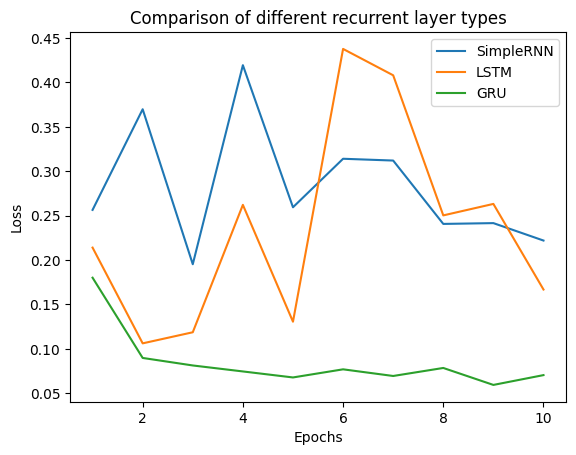

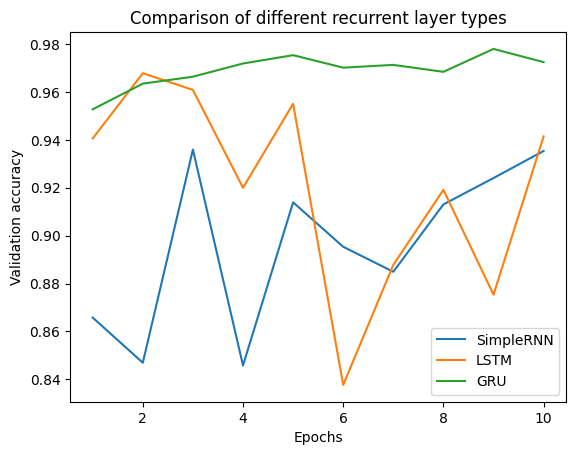

In [ ]:
import matplotlib.pyplot as plt

def plot_history(data_list, label_list, title, ylabel):
    ''' Plots a list of vectors.

    Parameters:
        data_list  : list of vectors containing the values to plot
        label_list : list of labels describing the data, one per vector
        title      : title of the plot
        ylabel     : label for the y axis
    '''
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

labels = ['SimpleRNN', 'LSTM', 'GRU']
plot_history(data_list=val_loss,
             label_list=labels,
             title='Comparison of different recurrent layer types',
             ylabel='Loss')
plot_history(data_list=val_acc,
             label_list=labels,
             title='Comparison of different recurrent layer types',
             ylabel='Validation accuracy')

We will use calculate_metrics function to calculate the evaluation metrics during this practical.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def calculate_metrics(model, X_test, y_test, threshold=0.5):
    # predict probabilities for test set
    yhat_probs = model.predict(X_test, verbose=0)
    # predict classes for test set
    yhat_classes = (yhat_probs > threshold).astype(int)

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % f1)

    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    print('ROC AUC: %f' % auc)

    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    print(matrix)

    results = [accuracy, precision, recall, f1, auc]
    return results

In [ ]:
score, acc = model_simpleRNN.evaluate(X_test_series, y_test)
print('Accuracy for simpleRNN model:',acc)
# predict probabilities for test set
yhat_probs_simpleRNN = model_simpleRNN.predict(X_test_series, verbose=0)
# predict classes for test set
yhat_classes_simpleRNN = np.where(yhat_probs_simpleRNN>0.5, 1, 0)

108/108 [==============================] - 2s 19ms/step - loss: 0.2220 - accuracy: 0.9354
Accuracy for simpleRNN model: 0.9353623390197754


The most common metric used to evaluate the performance of a classification predictive model is classification accuracy. When the class distribution is slightly skewed, accuracy can still be a useful metric. When the skew in the class distributions is severe, accuracy becomes an unreliable measure of model performance. Achieving over 90 % classification accuracy classification accuracy without even learning is possible with highly-unbalanced datasets.

This means that intuitions for classification accuracy developed on unbalanced class distributions could mislead us to think that a model has good or even excellent performance when it, in fact, does not.

Therefore, it is common to use alternative metrics to summarize model performance for imbalanced classification problems, since the accuracy results can be misleading. In cases of imbalance data we are provided with many metrics like Recall, Precision, F1 Score, AUC and much more.

ROC

In which aspects does it gives us the characteristics? Change the characteristics and maximize precision based on the ROC curve. Use Sigmoid function with a threshold of 0.5. Make it hard for a classifier to make a decision if you increase the threshold. Each number corresponds to a threshold. Use different thresholds. AUC can be at most one and it will look like a perfect rectangle.

In [ ]:
#In order to wrap the all results in a dataframe we will use a result list.
col_names = ['Model_name','Accuracy','Precision', 'Recall', 'F1 score','AUC']
all_results = []

#calculate all metrics
results = calculate_metrics(model_simpleRNN, X_test_series, y_test)

all_results.append(['SimpleRNN',results[0],results[1], results[2], results[3], results[4]])

Accuracy: 0.935362
Precision: 0.920354
Recall: 0.744986
F1 score: 0.823436
ROC AUC: 0.924027
[[2707   45]
 [ 178  520]]


One great tool for evaluating the behavior and undrestanding the effectiveness of a binary or categorical classifier is the **Confusion Matrix**. If you want a more aesthetically pleasing visualization of the confusion matrix, we can use a heatmap from the **Seaborn** library:

[Text(0, 0.5, 'non-seizure'), Text(0, 1.5, 'seizure')]

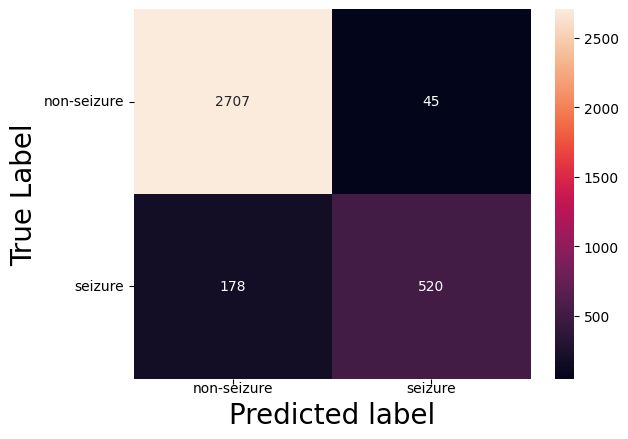

In [ ]:
import seaborn as sns
p = sns.heatmap(confusion_matrix(y_test, yhat_classes_simpleRNN), annot=True, fmt='g')
p.set_xlabel("Predicted label", fontsize = 20)
p.set_ylabel("True Label", fontsize = 20)
p.xaxis.set_ticklabels(['non-seizure', 'seizure'], ha="center", va="center")
p.yaxis.set_ticklabels(['non-seizure', 'seizure'], rotation=0, va="center")

### Plot the ROC Curve
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:
<center><span style="font-size: 150%">$ TPR = \frac{TP}{TP+FN} $</span></center>

False Positive Rate (FPR) is defined as follows:

<center><span style="font-size: 150%">$ FPR = \frac{FP}{FP+TN} $</span></center>

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

Note that the ROC does not depend on the class distribution. This makes it useful for evaluating classifiers predicting rare events such as diseases or disasters (for imbalance classification). In contrast, evaluating performance using accuracy (TP + TN)/(TP + TN + FN + FP) would favor classifiers that always predict a negative outcome for rare events.

The following we plot the ROC curve to evaluate the performance of our model:



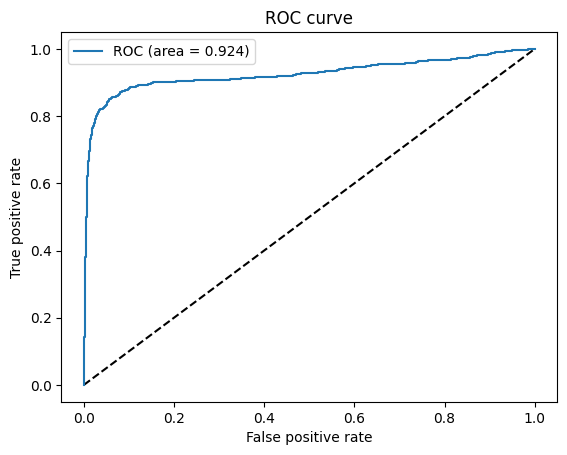

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, yhat_probs_simpleRNN)
auc_val = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (area = {:.3f})'.format(auc_val))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Results for LSTM Model

108/108 [==============================] - 9s 82ms/step - loss: 0.1668 - accuracy: 0.9414
Accuracy for LSTM model: 0.9414492845535278
Accuracy: 0.941449
Precision: 0.799517
Recall: 0.948424
F1 score: 0.867628
ROC AUC: 0.972810
[[2586  166]
 [  36  662]]


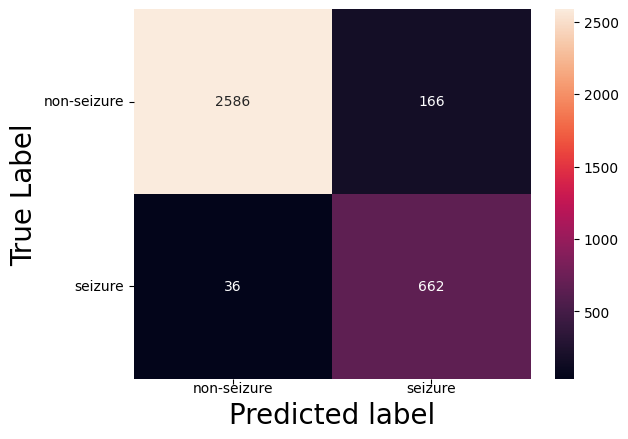

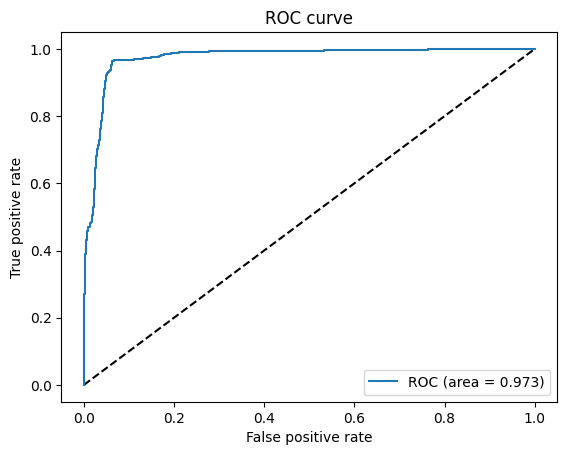

In [ ]:
score, acc = model_LSTM.evaluate(X_test_series, y_test)
print('Accuracy for LSTM model:',acc)
# predict probabilities for test set
yhat_probs_LSTM = model_LSTM.predict(X_test_series, verbose=0)
# predict classes for test set
yhat_classes_LSTM = np.where(yhat_probs_LSTM>0.5, 1, 0)

#Calculate all metrics
results = calculate_metrics(model_LSTM, X_test_series, y_test)
all_results.append(['LSTM',results[0],results[1], results[2], results[3], results[4]])

#plotting confusion matrix
import seaborn as sns
p = sns.heatmap(confusion_matrix(y_test, yhat_classes_LSTM), annot=True, fmt='g')
p.set_xlabel("Predicted label", fontsize = 20)
p.set_ylabel("True Label", fontsize = 20)
p.xaxis.set_ticklabels(['non-seizure', 'seizure'], ha="center", va="center")
p.yaxis.set_ticklabels(['non-seizure', 'seizure'], rotation=0, va="center")

#Plotting ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, yhat_probs_LSTM)
auc_val = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (area = {:.3f})'.format(auc_val))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Results for GRU Model

108/108 [==============================] - 5s 48ms/step - loss: 0.0705 - accuracy: 0.9725
Accuracy for GRU model: 0.9724637866020203
Accuracy: 0.972464
Precision: 0.905787
Recall: 0.964183
F1 score: 0.934074
ROC AUC: 0.996042
[[2682   70]
 [  25  673]]


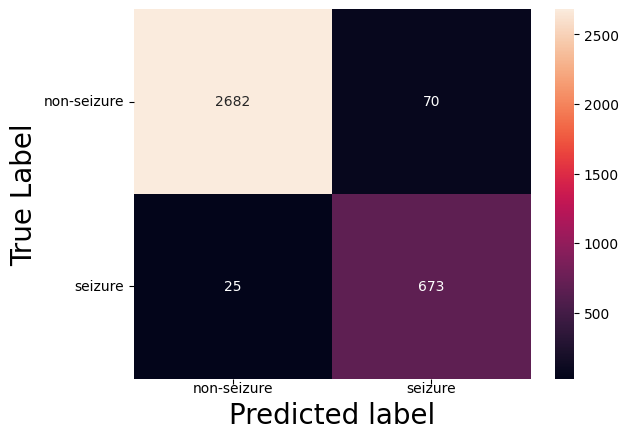

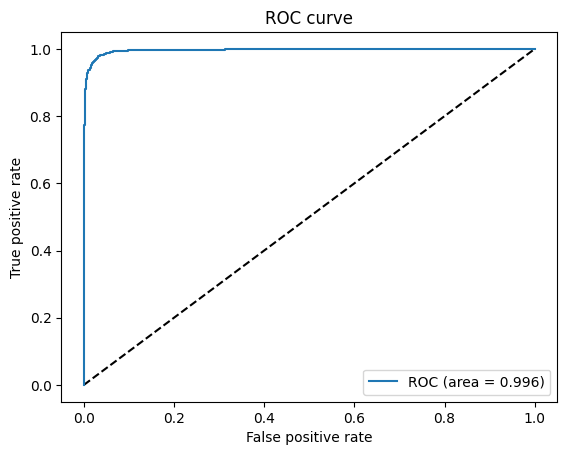

In [ ]:
score, acc = model_GRU.evaluate(X_test_series, y_test)
print('Accuracy for GRU model:',acc)
# predict probabilities for test set
yhat_probs_GRU = model_GRU.predict(X_test_series, verbose=0)
# predict classes for test set
yhat_classes_GRU = np.where(yhat_probs_GRU>0.5, 1, 0)

#calculate all metrics
results = calculate_metrics(model_GRU, X_test_series, y_test)
all_results.append(['GRU',results[0],results[1], results[2], results[3], results[4]])


#plotting confusion matrix
import seaborn as sns
p = sns.heatmap(confusion_matrix(y_test, yhat_classes_GRU), annot=True, fmt='g')
p.set_xlabel("Predicted label", fontsize = 20)
p.set_ylabel("True Label", fontsize = 20)
p.xaxis.set_ticklabels(['non-seizure', 'seizure'], ha="center", va="center")
p.yaxis.set_ticklabels(['non-seizure', 'seizure'], rotation=0, va="center")

#Plotting ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, yhat_probs_GRU)
auc_val = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (area = {:.3f})'.format(auc_val))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Exercise 3 - Building CNN-LSTM model

* Input shape **[samples, subsequences, timesteps, features]**.


> The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model.
>
> When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence.
>
> The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction.

#### Data preprocess
* Reshape from **[samples, timesteps, features]** into **[samples, subsequences, timesteps, features]**.

*samples*: The number of samples or observations in your dataset. This could be, for example, the number of EEG recordings you have.

*subsequences*: The number of subsequences into which you divide each sample. This is often referred to as the "number of frames" or "frames per sample." Each subsequence represents a time window or segment of the signal.

*timesteps*: The number of time steps in each subsequence. In the case of EEG signals, this is typically the number of time points in each segment.

*features*: The number of features or channels in each time step. For EEG signals, this would typically be the number of electrodes or channels.

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

Train set shape (8050, 2, 89, 1)
Test set shape (3450, 2, 89, 1)


In this model, you should initialize the Model and add a TimeDistributed Conv1D layer with parameters: 64 filters, 3x3 kernel size, and ReLU activation. (by defining the input shape with time steps, feature shape, and channel count).
- Include a TimeDistributed MaxPooling1D layer with a pool size of 2, then add a TimeDistributed flatten layer.
- Then incorporate an LSTM layer with 50 units and ReLU activation.
- Then complete the model with an appropriate output layer.
Compile the model with 'binary_crossentropy' loss, 'adam' optimizer, and 'accuracy' metric.

TimeDistributed layer allows us to apply convolutional layers to each frame of a sequence of input data in a CNN-LSTM network. You can refer to [here](https://keras.io/api/layers/recurrent_layers/time_distributed/) for more information about TimeDistributed layers in Keras.


In [ ]:
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten
def build_model():
  ### PUT YOUR CODE HERE ###
  model = Sequential ()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  ### END ###
  return model

model_cnn_lstm = build_model()
model_cnn_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 87, 64)      256       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 43, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 2752)        0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 50)                560600    
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                      

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, y_train, validation_data=(X_test_series_sub, y_test), epochs=10, verbose=2)
score, acc = model_cnn_lstm.evaluate(X_test_series_sub, y_test)

Epoch 1/10
252/252 - 7s - loss: 0.1446 - accuracy: 0.9575 - val_loss: 0.0935 - val_accuracy: 0.9655 - 7s/epoch - 26ms/step
Epoch 2/10
252/252 - 6s - loss: 0.0686 - accuracy: 0.9750 - val_loss: 0.0644 - val_accuracy: 0.9780 - 6s/epoch - 25ms/step
Epoch 3/10
252/252 - 4s - loss: 0.0560 - accuracy: 0.9785 - val_loss: 0.0678 - val_accuracy: 0.9774 - 4s/epoch - 17ms/step
Epoch 4/10
252/252 - 4s - loss: 0.0477 - accuracy: 0.9845 - val_loss: 0.0679 - val_accuracy: 0.9765 - 4s/epoch - 17ms/step
Epoch 5/10
252/252 - 6s - loss: 0.0438 - accuracy: 0.9843 - val_loss: 0.0752 - val_accuracy: 0.9728 - 6s/epoch - 24ms/step
Epoch 6/10
252/252 - 5s - loss: 0.0363 - accuracy: 0.9887 - val_loss: 0.0631 - val_accuracy: 0.9794 - 5s/epoch - 19ms/step
Epoch 7/10
252/252 - 5s - loss: 0.0286 - accuracy: 0.9902 - val_loss: 0.0621 - val_accuracy: 0.9788 - 5s/epoch - 21ms/step
Epoch 8/10
252/252 - 5s - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.0721 - val_accuracy: 0.9751 - 5s/epoch - 21ms/step
Epoch 9/10
252/2

In [ ]:
# predict probabilities for test set
yhat_probs_cnnlstm = model_cnn_lstm.predict(X_test_series_sub, verbose=0)
# predict classes for test set
yhat_classes_cnnlstm = np.where(yhat_probs_cnnlstm>0.5, 1, 0)

#calculate all metrics
results = calculate_metrics(model_cnn_lstm, X_test_series_sub, y_test)
all_results.append(['CNN-LSTM',results[0],results[1], results[2], results[3], results[4]])

Accuracy: 0.980290
Precision: 0.961877
Recall: 0.939828
F1 score: 0.950725
ROC AUC: 0.995471
[[2726   26]
 [  42  656]]


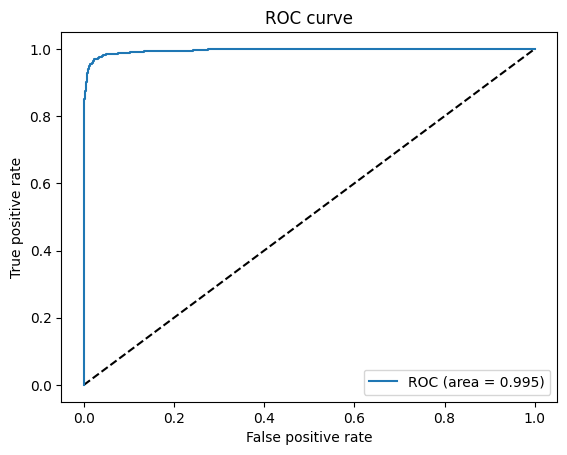

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, yhat_probs_cnnlstm)
auc_val = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (area = {:.3f})'.format(auc_val))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Comparing models

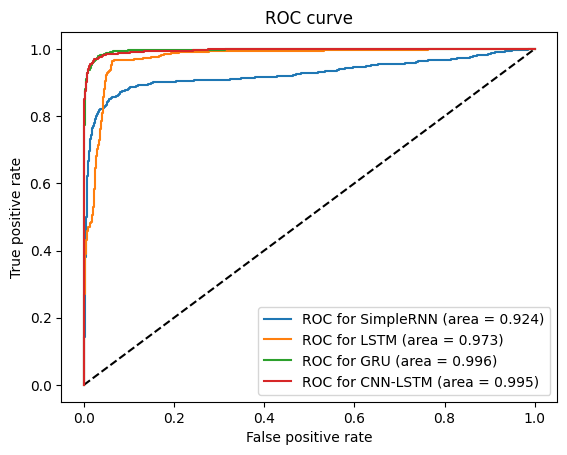

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, threshold1 = roc_curve(y_test, model_simpleRNN.predict(X_test_series, verbose=0))
fpr2, tpr2, threshold2 = roc_curve(y_test, model_LSTM.predict(X_test_series, verbose=0))
fpr3, tpr3, threshold3 = roc_curve(y_test, model_GRU.predict(X_test_series, verbose=0))
fpr4, tpr4, threshold24 = roc_curve(y_test, model_cnn_lstm.predict(X_test_series_sub, verbose=0))
auc_val_simpleRNN = auc(fpr1, tpr1)
auc_val_LSTM = auc(fpr2, tpr2)
auc_val_GRU = auc(fpr3, tpr3)
auc_val_cnnlstm = auc(fpr4, tpr4)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='ROC for SimpleRNN (area = {:.3f})'.format(auc_val_simpleRNN))
plt.plot(fpr2, tpr2, label='ROC for LSTM (area = {:.3f})'.format(auc_val_LSTM))
plt.plot(fpr3, tpr3, label='ROC for GRU (area = {:.3f})'.format(auc_val_GRU))
plt.plot(fpr4, tpr4, label='ROC for CNN-LSTM (area = {:.3f})'.format(auc_val_cnnlstm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
all_results_df = pd.DataFrame(all_results, columns=col_names)
all_results_df

,Model_name,Accuracy,Precision,Recall,F1 score,AUC
0,SimpleRNN,0.935362,0.920354,0.744986,0.823436,0.924027
1,LSTM,0.941449,0.799517,0.948424,0.867628,0.972810
2,GRU,0.972464,0.905787,0.964183,0.934074,0.996042
3,CNN-LSTM,0.980290,0.961877,0.939828,0.950725,0.995471


# Wrapping up:

In this practical, you will discover how to develop a recurrent neural network model and how to apply it on EEG data.

Here's what you should take away from this example:

* When you are working with RNN models, you should reshape your input data according to model so that it can be trained sequentially by the layers.
* In recurrent neural networks such as the long short-term memory (LSTM), the sigmoid and hyperbolic tangent functions are commonly used as activation functions in the network units.
* When you are dealing with an imbalanced dataset, you must choose a metric that best captures what is important about predictions. The F1-Score is a popular metric for imbalanced classification. Always keep in mind that relying on just one metric such as accuracy can be misleading.
